# Prepare Covid-19 temporal series

In [214]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gamma, lognorm
from datetime import datetime
import epyestim
import epyestim.covid19 as covid19
from math import exp
from detecta import detect_peaks

## Reading data

Covid data: https://github.com/wcota/covid19br

In [215]:
df_wcota = pd.concat([pd.read_csv(x) for x in sorted(glob.glob('data/input/covid/cases-brazil-cities-time_2*.csv.gz'))])

In [216]:
df_wcota.date = pd.to_datetime(df_wcota.date, infer_datetime_format=True)

In [217]:
df_wcota = df_wcota.rename(columns={'epi_week': 'SEMANA_EPIDEMIOLOGICA', 'date': 'DATA', 'state': 'SIGLA_ESTADO', 'city': 'MUNICIPIO', 'ibgeID': 'CODIGO_MUNICIPIO_7', 'newDeaths': 'OBITOS_NOVOS', 'deaths': 'OBITOS', 'newCases': 'CASOS_NOVOS', 'totalCases': 'CASOS'})

In [218]:
df_wcota

,SEMANA_EPIDEMIOLOGICA,DATA,SIGLA_ESTADO,MUNICIPIO,CODIGO_MUNICIPIO_7,OBITOS_NOVOS,OBITOS,CASOS_NOVOS,CASOS,deaths_per_100k_inhabitants,totalCases_per_100k_inhabitants,deaths_by_totalCases
0,9,2020-02-25,SP,São Paulo/SP,3550308,0,0,1,1,0.000,0.008,0.000
1,9,2020-02-25,TOTAL,TOTAL,0,0,0,1,1,0.000,0.000,0.000
2,9,2020-02-26,SP,São Paulo/SP,3550308,0,0,0,1,0.000,0.008,0.000
3,9,2020-02-26,TOTAL,TOTAL,0,0,0,0,1,0.000,0.000,0.000
4,9,2020-02-27,SP,São Paulo/SP,3550308,0,0,0,1,0.000,0.008,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
1858199,248,2022-11-28,PR,Ângulo/PR,4101150,0,11,0,926,375.299,31593.313,0.012
1858200,248,2022-11-28,BA,Érico Cardoso/BA,2900504,0,6,0,667,57.072,6344.526,0.009
1858201,248,2022-11-28,PA,Óbidos/PA,1505106,0,165,0,8622,314.447,16431.308,0.019
1858202,248,2022-11-28,SP,Óleo/SP,3533809,0,6,0,161,245.198,6579.485,0.037


## Adjusting data

In [221]:
STUDY_END_DATE = datetime.fromisoformat('2022-10-15')

In [222]:
df_covid_base = df_wcota[['DATA', 'SIGLA_ESTADO', 'MUNICIPIO', 'CODIGO_MUNICIPIO_7', 'OBITOS_NOVOS', 'OBITOS', 'CASOS_NOVOS', 'CASOS']]

In [223]:
df_covid_base = df_covid_base[df_covid_base.DATA <= STUDY_END_DATE]

In [227]:
df_ts_covid_brazil = df_covid_base[df_covid_base.MUNICIPIO == 'TOTAL'].copy()
# Population estimated for Brazil second IBGE
df_ts_covid_brazil['POPULACAO_ESTIMADA'] = 210147125

## National dataframe

### Defining Covid-19 rolling averge measures

In [228]:
df_ts_covid_brazil = df_ts_covid_brazil.sort_values(by='DATA')
df_ts_covid_brazil['OBITOS_NOVOS_MEDIA_14_DIAS'] = df_ts_covid_brazil[['OBITOS_NOVOS']].rolling(window=14, min_periods=1).mean()
df_ts_covid_brazil['TAXA_OBITOS_NOVOS_MEDIA_14_DIAS'] = df_ts_covid_brazil.OBITOS_NOVOS_MEDIA_14_DIAS / df_ts_covid_brazil.POPULACAO_ESTIMADA * 100000
df_ts_covid_brazil['CASOS_NOVOS_MEDIA_14_DIAS'] = df_ts_covid_brazil[['CASOS_NOVOS']].rolling(window=14, min_periods=1).mean()
df_ts_covid_brazil['CASOS_NOVOS_MEDIA_56_DIAS'] = df_ts_covid_brazil[['CASOS_NOVOS']].rolling(window=56, min_periods=1).mean()
df_ts_covid_brazil['TAXA_CASOS_NOVOS_MEDIA_14_DIAS'] = df_ts_covid_brazil.CASOS_NOVOS_MEDIA_14_DIAS / df_ts_covid_brazil.POPULACAO_ESTIMADA * 100000
df_ts_covid_brazil['TAXA_CASOS_NOVOS_MEDIA_56_DIAS'] = df_ts_covid_brazil.CASOS_NOVOS_MEDIA_56_DIAS / df_ts_covid_brazil.POPULACAO_ESTIMADA * 100000

### Defining epidemiological measures

In [229]:
# Baud, David, et al. "Real estimates of mortality following COVID-19 infection." The Lancet infectious diseases 20.7 (2020): 773.
df_ts_covid_brazil['TAXA_FATALIDADE'] = df_ts_covid_brazil.OBITOS_NOVOS_MEDIA_14_DIAS / df_ts_covid_brazil.CASOS_NOVOS_MEDIA_14_DIAS.shift(14) * 100

/home/helder/Codigos/Python/PesquisasCovid19/main/qualification/util.py:89: RuntimeWarning: divide by zero encountered in true_divide
  re = (new_cases[14:]) / (new_cases[:len(new_cases) - 14])
/home/helder/Codigos/Python/PesquisasCovid19/main/qualification/util.py:89: RuntimeWarning: invalid value encountered in true_divide
  re = (new_cases[14:]) / (new_cases[:len(new_cases) - 14])


#### Estimating effective reproduction number for national time series

In [232]:
df_cases = df_ts_covid_brazil.set_index('DATA')['CASOS_NOVOS']

In [233]:
#Bi, Qifang, et al. "Epidemiology and transmission of COVID-19 in 391 cases and 1286 of their close contacts in Shenzhen, China: a retrospective cohort study." The Lancet infectious diseases 20.8 (2020): 911-919.
# Gamma distribution with serial interval mean equal to 6.36 days, gamma(a=2.29, b=0.36)
standard_serial_inteval_distribution = epyestim.discrete_distrb(gamma(a=2.29, scale=1/0.36))

#Bi, Qifang, et al. "Epidemiology and transmission of COVID-19 in 391 cases and 1286 of their close contacts in Shenzhen, China: a retrospective cohort study." The Lancet infectious diseases 20.8 (2020): 911-919.
# Lognormal distribution with incabation mean equal to 5.93 days, Lognormal(mu=1.57, sigma²=0.42)
incubation_time_distribution = epyestim.discrete_distrb(lognorm(scale=exp(1.57), s=0.65))

#Barros, Gabriela Pereira, et al. "Estimation of Reproduction Number for Covid-19 with Statistical Correction of Notifications Delay." IEEE Latin America Transactions 20.7 (2022): 1085-1091.
#Gamma distribution for BH city with mean equal 6.56 days SD 5.34, gamma(a=1.51, b=0.23)
delay_onset_to_notification_distribution = epyestim.discrete_distrb(gamma(a=1.51, scale=1/0.23))

# Distribution resultant of convolution incubation_time_distribution and delay_onset_to_notification_distribution.
# Represent delay of infection to notification with delay mean equal to 12.5 days.
delay_infecton_to_notification_distribution = np.convolve(incubation_time_distribution, delay_onset_to_notification_distribution)

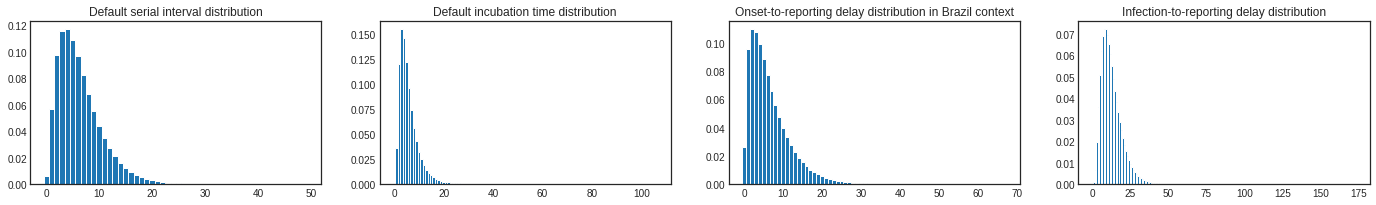

In [234]:
fig, axs = plt.subplots(1, 4, figsize=(24,3))

axs[0].bar(range(len(standard_serial_inteval_distribution)), standard_serial_inteval_distribution, width=1)
axs[1].bar(range(len(incubation_time_distribution)), incubation_time_distribution, width=1)
axs[2].bar(range(len(delay_onset_to_notification_distribution)), delay_onset_to_notification_distribution, width=1)
# axs[3].bar(range(50), delay_infecton_to_notification_distribution[:50], width=1)
axs[3].bar(range(len(delay_infecton_to_notification_distribution)), delay_infecton_to_notification_distribution, width=1)

axs[0].set_title('Default serial interval distribution')
axs[1].set_title('Default incubation time distribution')
axs[2].set_title('Onset-to-reporting delay distribution in Brazil context')
axs[3].set_title('Infection-to-reporting delay distribution')
plt.show()

In [235]:
# Cori, A., Ferguson, N. M., Fraser, C., & Cauchemez, S. (2013). A new framework and software to estimate time-varying reproduction numbers during epidemics. American journal of epidemiology, 178(9), 1505-1512.
# https://github.com/lo-hfk/epyestim
# df_effective_reproduction_number = covid19.r_covid(df_cases, smoothing_window = 56, r_window_size = 14, auto_cutoff=True, n_samples=10, delay_distribution=delay_infecton_to_notification_distribution, gt_distribution=standard_serial_inteval_distribution)
df_effective_reproduction_number = covid19.r_covid(df_cases, smoothing_window = 28, r_window_size = 14, auto_cutoff=True, n_samples=10, delay_distribution=delay_infecton_to_notification_distribution, gt_distribution=standard_serial_inteval_distribution, a_prior=9.9, b_prior=1/9.25)
df_effective_reproduction_number

,cases,R_mean,R_var,Q0.025,Q0.5,Q0.975
2020-03-10,9.0,3.074052,0.006483,2.919447,3.073360,3.232590
2020-03-11,19.0,2.903070,0.004841,2.769328,2.902523,3.039922
2020-03-12,36.0,2.742147,0.003656,2.625360,2.741699,2.862309
2020-03-13,17.0,2.602817,0.002816,2.499764,2.602456,2.707923
2020-03-14,36.0,2.487134,0.002215,2.395839,2.486837,2.580111
...,...,...,...,...,...,...
2022-09-29,9541.0,0.902853,0.000010,0.896663,0.902849,0.909064
2022-09-30,8793.0,0.895135,0.000010,0.888928,0.895131,0.901364
2022-10-01,5986.0,0.887374,0.000010,0.881134,0.887370,0.893636
2022-10-02,1023.0,0.879455,0.000010,0.873188,0.879451,0.885744


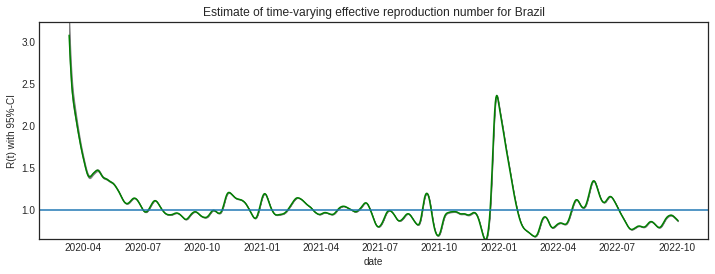

In [236]:
fig, ax = plt.subplots(1,1, figsize=(12, 4))

plt.plot(df_effective_reproduction_number.index, df_effective_reproduction_number['R_mean'], color='green')

ax.fill_between(df_effective_reproduction_number.index,
                    df_effective_reproduction_number['Q0.025'],
                    df_effective_reproduction_number['Q0.975'],
                    color='gray', alpha=1)
ax.set_xlabel('date')
ax.set_ylabel('R(t) with 95%-CI')
ax.set_ylim([df_effective_reproduction_number['Q0.975'].min(),df_effective_reproduction_number['Q0.975'].max()])
ax.axhline(y=1)
ax.set_title('Estimate of time-varying effective reproduction number for Brazil')
plt.show()

In [237]:
df_effective_reproduction_number

,cases,R_mean,R_var,Q0.025,Q0.5,Q0.975
2020-03-10,9.0,3.074052,0.006483,2.919447,3.073360,3.232590
2020-03-11,19.0,2.903070,0.004841,2.769328,2.902523,3.039922
2020-03-12,36.0,2.742147,0.003656,2.625360,2.741699,2.862309
2020-03-13,17.0,2.602817,0.002816,2.499764,2.602456,2.707923
2020-03-14,36.0,2.487134,0.002215,2.395839,2.486837,2.580111
...,...,...,...,...,...,...
2022-09-29,9541.0,0.902853,0.000010,0.896663,0.902849,0.909064
2022-09-30,8793.0,0.895135,0.000010,0.888928,0.895131,0.901364
2022-10-01,5986.0,0.887374,0.000010,0.881134,0.887370,0.893636
2022-10-02,1023.0,0.879455,0.000010,0.873188,0.879451,0.885744


In [238]:
df_effective_reproduction_number = df_effective_reproduction_number.reset_index()
df_effective_reproduction_number = df_effective_reproduction_number.rename(columns={'index': 'DATA', 'R_mean': 'NUMERO_REPRODUCAO_EFETIVO_MEDIA', 'R_var': 'NUMERO_REPRODUCAO_EFETIVO_VARIANCIA', 'Q0.025': 'NUMERO_REPRODUCAO_EFETIVO_QUANTIL_0.025', 'Q0.5': 'NUMERO_REPRODUCAO_EFETIVO_MEDIANA', 'Q0.975': 'NUMERO_REPRODUCAO_EFETIVO_QUANTIL_0.975' })
df_effective_reproduction_number = df_effective_reproduction_number.drop(columns=['cases'])
df_ts_covid_brazil = df_ts_covid_brazil.merge(df_effective_reproduction_number, how='left', left_on='DATA', right_on='DATA')

## Peaks and valleys

In [ ]:
index_case_peaks = detect_peaks(df_ts_covid_brazil.CASOS_NOVOS_MEDIA_14_DIAS, mph=df_ts_covid_brazil.CASOS_NOVOS_MEDIA_14_DIAS.std() * 1.5, mpd=120, show=True)

case_peaks = []
for i in index_case_peaks:
    case_peaks.append(df_ts_covid_brazil.iloc[i].DATA)
pd.DataFrame(case_peaks).to_csv("data/output/peaks.csv", index=False, header=False)

index_case_valleys = detect_peaks(df_ts_covid_brazil.CASOS_NOVOS_MEDIA_14_DIAS, mph=19000, mpd=120, threshold=1, valley=True, show=True)
case_valleys = []
for i in index_case_valleys:
    case_valleys.append(df_ts_covid_brazil.iloc[i].DATA)
    print(df_ts_covid_brazil.iloc[i].CASOS_NOVOS_MEDIA_14_DIAS)
pd.DataFrame(case_valleys).to_csv("data/output/valleys.csv", index=False, header=False)

## Saving data

In [247]:
df_ts_covid_brazil.to_csv('data/df_ts_covid_brazil.csv', index=False)